# Mining Big Data - Assignment 3: Pattern Mining (Business Applications)
===========================================================

# Notebook 3: Applying Pattern Mining for Business Insights and Recommendations

## 1. Introduction

This notebook demonstrates how to apply pattern mining techniques to extract actionable business insights from transaction data. We'll cover:
- Translating pattern mining results into business recommendations
- Segmenting customer behavior
- Measuring the business impact of discovered patterns
- Creating a recommendation engine based on association rules
- Visualizing insights for business stakeholders

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
import os
from IPython.display import display, HTML

## 3. Load and Prepare Dataset

Dataset shape: (26985, 7)
Number of unique users: 3493
Number of unique items: 167


,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351.0,1/01/2014,cleaner,2014.0,1.0,1.0,2.0
1,2226.0,1/01/2014,sausage,2014.0,1.0,1.0,2.0
2,1922.0,1/01/2014,tropical fruit,2014.0,1.0,1.0,2.0
3,2943.0,1/01/2014,whole milk,2014.0,1.0,1.0,2.0
4,1249.0,1/01/2014,citrus fruit,2014.0,1.0,1.0,2.0



Missing values in dataset:
User_id            7603
Date               7603
itemDescription    7603
year               7603
month              7603
day                7603
day_of_week        7603
dtype: int64
Dataset shape after cleaning: (19382, 7)


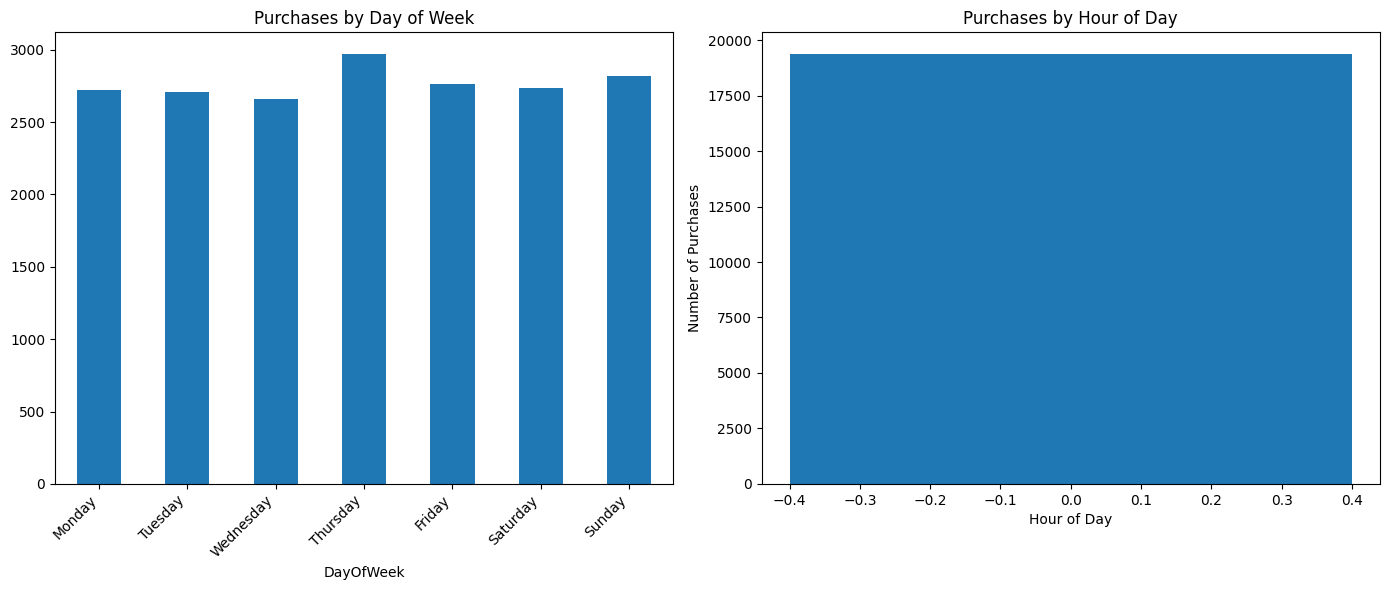

In [3]:
# Load dataset
# Note: The path was corrected to '../dataset' in the user's snippet. 
# Ensure this path is correct relative to where your notebook is saved.
train_path = os.path.join('../dataset', 'train.csv')
try:
    train_data = pd.read_csv(train_path)
except FileNotFoundError:
    print(f"Error: The file was not found at {train_path}")
    print("Please check the path to your 'train.csv' file.")
    # Exit or handle the error appropriately, e.g., load a dummy dataframe
    # For demonstration, let's assume it will be run where the path is correct.
    # You might need to adjust '../dataset' based on your directory structure.
    pass # Remove this 'pass' if you expect the file to be there

print(f"Dataset shape: {train_data.shape}")
print(f"Number of unique users: {train_data['User_id'].nunique()}")
print(f"Number of unique items: {train_data['itemDescription'].nunique()}")

# Preview the data
display(train_data.head())

# Check for and handle missing values
print(f"\nMissing values in dataset:")
print(train_data.isnull().sum())

train_data = train_data.dropna(subset=['itemDescription'])
print(f"Dataset shape after cleaning: {train_data.shape}")

# Add time features
if 'Date' in train_data.columns:
    # FIX: Add dayfirst=True or specify the format to correctly parse the date string
    # The error message indicates the format is DD/MM/YYYY
    try:
        train_data['Date'] = pd.to_datetime(train_data['Date'], dayfirst=True)
        # Alternative: train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d/%m/%Y')
        # Alternative: train_data['Date'] = pd.to_datetime(train_data['Date'], format='mixed', dayfirst=True, errors='coerce') # Use errors='coerce' to turn unparseable dates into NaT
        
        train_data['DayOfWeek'] = train_data['Date'].dt.day_name()
        train_data['Month'] = train_data['Date'].dt.month_name()
        train_data['Hour'] = train_data['Date'].dt.hour
        
        # Analyze purchase times
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        # Reorder days of week for logical plotting
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = train_data['DayOfWeek'].value_counts().reindex(day_order)
        day_counts.plot(kind='bar') # Using pandas plot for convenience
        plt.title('Purchases by Day of Week')
        plt.xticks(rotation=45, ha='right') # Adjust rotation and alignment
        
        plt.subplot(1, 2, 2)
        hour_counts = train_data['Hour'].value_counts().sort_index()
        plt.bar(hour_counts.index, hour_counts.values)
        plt.title('Purchases by Hour of Day')
        plt.xlabel('Hour of Day') # Add x-label for clarity
        plt.ylabel('Number of Purchases') # Add y-label for clarity
        
        plt.tight_layout()
        plt.show()
        
    except ValueError as e:
        print(f"Error parsing dates: {e}")
        print("Date column might contain inconsistent formats or non-date values.")
        # You might need to inspect train_data['Date'].unique() to find problematic values
        # Or use errors='coerce' in pd.to_datetime to skip problematic rows/values
    except Exception as e:
         print(f"An unexpected error occurred during date processing or plotting: {e}")

else:
    print("'Date' column not found in the dataset. Skipping time-based analysis.")

## 4. Customer Segmentation Analysis

User-item matrix shape: (3493, 167)
Clustering will be performed using only purchase count and unique items.

User profile statistics:


,purchase_count,unique_items
count,3493.000000,3493.000000
mean,5.548812,5.235614
std,3.238378,2.906183
min,1.000000,1.000000
25%,3.000000,3.000000
50%,5.000000,5.000000
75%,7.000000,7.000000
max,24.000000,21.000000


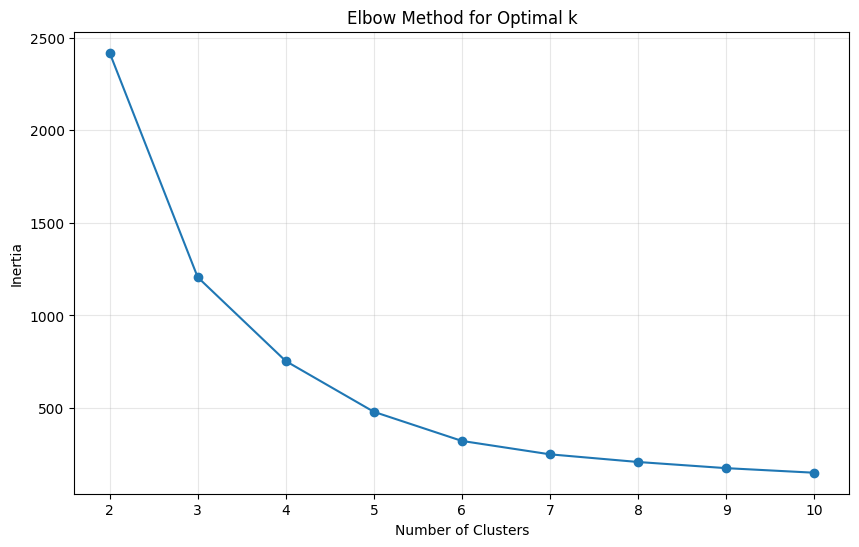


Cluster profiles (Averages):


,purchase_count,unique_items
Cluster,,
0,5.048319,4.842437
1,8.580524,8.057428
2,13.514019,12.163551
3,2.293333,2.205714


Plotting customer segments (Purchase Count vs Unique Items) as 'Amount' column is missing.


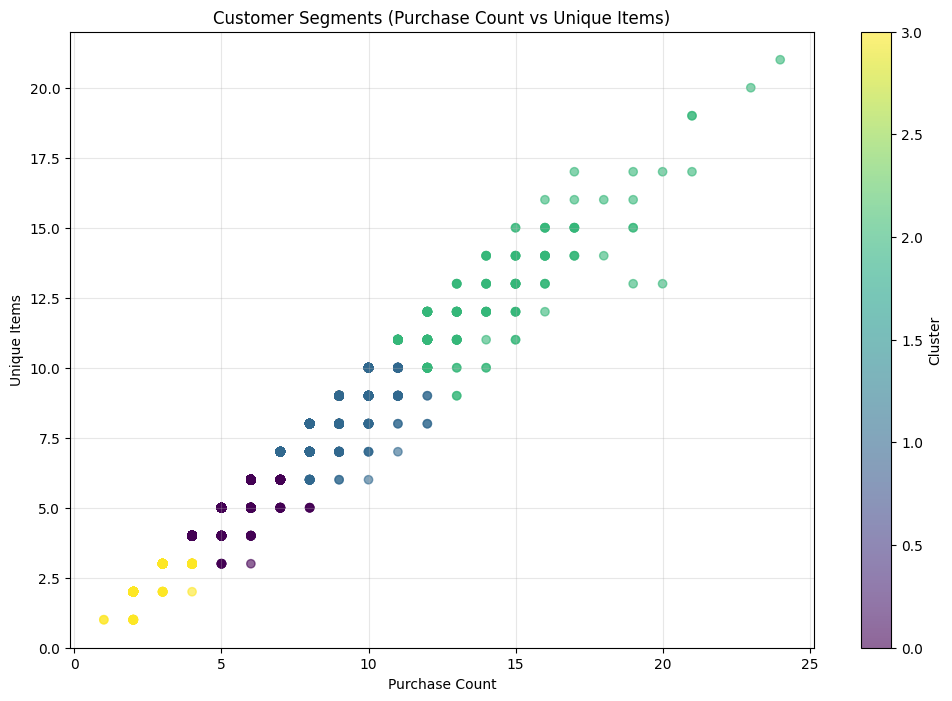


Cluster Business Interpretation (Based on average profiles):
Segment 1 (Cluster 0):
  Number of customers in segment: 1428
  Average purchases: 5.0
  Average unique items: 4.8
  Average spend: N/A ('Amount' column missing)

Segment 2 (Cluster 1):
  Number of customers in segment: 801
  Average purchases: 8.6
  Average unique items: 8.1
  Average spend: N/A ('Amount' column missing)

Segment 3 (Cluster 2):
  Number of customers in segment: 214
  Average purchases: 13.5
  Average unique items: 12.2
  Average spend: N/A ('Amount' column missing)

Segment 4 (Cluster 3):
  Number of customers in segment: 1050
  Average purchases: 2.3
  Average unique items: 2.2
  Average spend: N/A ('Amount' column missing)



In [5]:
# Create user-item purchase frequency matrix
user_item_matrix = train_data.groupby(['User_id', 'itemDescription']).size().unstack(fill_value=0)
print(f"User-item matrix shape: {user_item_matrix.shape}")

# Compute user purchase profiles
user_profiles = {}
user_profiles['purchase_count'] = train_data.groupby('User_id').size()
user_profiles['unique_items'] = train_data.groupby('User_id')['itemDescription'].nunique()

# FIX: Check if 'Amount' column exists before calculating average price
if 'Amount' in train_data.columns:
    user_profiles['avg_price'] = train_data.groupby('User_id')['Amount'].mean()
    print("Calculating user profiles including purchase count, unique items, and average spending.")
    features_for_clustering = ['purchase_count', 'unique_items', 'avg_price']
else:
    print("Warning: 'Amount' column not found. Cannot calculate average spending per user.")
    print("Clustering will be performed using only purchase count and unique items.")
    features_for_clustering = ['purchase_count', 'unique_items']


# Combine into a single DataFrame
user_profile_df = pd.DataFrame(user_profiles)
print("\nUser profile statistics:")
display(user_profile_df.describe())

# Check if there are enough users to perform clustering
if len(user_profile_df) < 2:
    print("\nCannot perform clustering: Need at least 2 users.")
    user_profile_df['Cluster'] = -1 # Assign a default cluster if clustering is skipped
    cluster_profiles = pd.DataFrame() # Empty cluster profiles
    cluster_labels = {} # Empty labels
    print("Skipping clustering and related visualizations/analysis.")

else:
    # Cluster users by behavior using available features
    scaler = StandardScaler()
    # Ensure we only scale the columns that exist in the DataFrame
    scaled_profiles = scaler.fit_transform(user_profile_df[features_for_clustering].fillna(0))

    # Determine optimal number of clusters
    # Ensure k_range is valid based on the number of samples
    k_range_end = min(11, len(user_profile_df))
    k_range = range(2, k_range_end)

    if len(k_range) < 2:
        print(f"Cannot perform Elbow method: Need at least 2 values in k_range (found {len(k_range)}). Skipping.")
        # Default to k=min(4, number of users) if elbow not feasible
        k = min(4, len(user_profile_df))
        print(f"Defaulting to k={k} for clustering.")
        inertia = [] # Empty inertia list
    else:
        inertia = []
        for k in k_range:
            # Added n_init to explicitly set initialization method and suppress warning
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(scaled_profiles)
            inertia.append(kmeans.inertia_)

        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, 'o-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Apply KMeans with optimal k (let's say 4 for this example, but adaptable)
        # You should visually inspect the Elbow plot to choose the best k.
        # For demonstration, we'll pick 4 if possible, otherwise the max k from the range.
        k = 4
        if k not in k_range:
            if len(k_range) > 0:
                k = k_range[-1] # Use the largest possible k if 4 is not in range
                print(f"Adjusting k to {k} as 4 is not feasible with current data size.")
            else: # Should be caught by the len(user_profile_df) < 2 check, but safety net
                 k = len(user_profile_df) # Cluster into number of users if <=1
                 print(f"Adjusting k to {k} (number of users) as range is invalid.")


        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init
        user_profile_df['Cluster'] = kmeans.fit_predict(scaled_profiles)

        # Analyze clusters
        # Ensure we only compute mean for features used in clustering + Cluster column
        cols_to_group = features_for_clustering + ['Cluster']
        cluster_profiles = user_profile_df[cols_to_group].groupby('Cluster').mean()
        print("\nCluster profiles (Averages):")
        display(cluster_profiles)

        # Visualize clusters
        plt.figure(figsize=(12, 8))
        # No need for specific colors list if using cmap='viridis' with plotly or matplotlib

        # 3D plot if 'avg_price' is available and plotly is working, otherwise fallback to 2D
        if 'avg_price' in user_profile_df.columns:
            try:
                print("Attempting 3D plot for customer segments.")
                fig = px.scatter_3d(
                    user_profile_df,
                    x='purchase_count',
                    y='unique_items',
                    z='avg_price',
                    color='Cluster',
                    title='Customer Segments (Purchase Count, Unique Items, Avg Price)',
                    hover_data=['Cluster'] # Show cluster on hover
                )
                fig.update_layout(scene=dict(xaxis_title='Purchase Count', yaxis_title='Unique Items', zaxis_title='Average Price'))
                fig.show()
            except Exception as e:
                print(f"Plotly 3D plot failed (likely plotly not installed or issue): {e}. Falling back to 2D plot.")
                # Fallback plot
                plt.scatter(
                    user_profile_df['purchase_count'],
                    user_profile_df['unique_items'],
                    c=user_profile_df['Cluster'],
                    cmap='viridis',
                    alpha=0.6
                )
                plt.xlabel('Purchase Count')
                plt.ylabel('Unique Items')
                plt.title('Customer Segments (Purchase Count vs Unique Items)')
                plt.colorbar(label='Cluster')
                plt.grid(True, alpha=0.3)
                plt.show()
        else:
             print("Plotting customer segments (Purchase Count vs Unique Items) as 'Amount' column is missing.")
             plt.scatter(
                user_profile_df['purchase_count'],
                user_profile_df['unique_items'],
                c=user_profile_df['Cluster'],
                cmap='viridis',
                alpha=0.6
            )
             plt.xlabel('Purchase Count')
             plt.ylabel('Unique Items')
             plt.title('Customer Segments (Purchase Count vs Unique Items)')
             plt.colorbar(label='Cluster')
             plt.grid(True, alpha=0.3)
             plt.show()


        # Label the clusters for business context
        # These are example labels. You should examine cluster_profiles to name them appropriately.
        cluster_labels = {i: f"Segment {i+1}" for i in range(k)} # Generate generic labels initially
        # Example manual labeling based on typical interpretations:
        # if 'avg_price' in cluster_profiles.columns:
        #     # Compare cluster_profiles values to assign meaningful names
        #     # e.g., find cluster with highest avg_price -> "High-Value Customers"
        #     # find cluster with highest purchase_count -> "Loyal Regulars" etc.
        #     pass # Implement actual labeling based on your data's cluster characteristics
        # else:
        #     # Interpret based on purchase_count and unique_items
        #     pass # Implement actual labeling based on your data's cluster characteristics

        print("\nCluster Business Interpretation (Based on average profiles):")
        for cluster, label in cluster_labels.items():
            print(f"{label} (Cluster {cluster}):")
            # Check if the cluster exists in the calculated profiles
            if cluster in cluster_profiles.index:
                profile_data = cluster_profiles.loc[cluster]
                print(f"  Number of customers in segment: {int(user_profile_df[user_profile_df['Cluster'] == cluster].shape[0])}")
                print(f"  Average purchases: {profile_data.get('purchase_count', 0):.1f}")
                print(f"  Average unique items: {profile_data.get('unique_items', 0):.1f}")
                if 'avg_price' in profile_data:
                    print(f"  Average spend: ${profile_data['avg_price']:.2f}")
                else:
                    print("  Average spend: N/A ('Amount' column missing)")
            else:
                print(f"  Cluster {cluster} profile data not available (possibly due to small segment size).")
            print()

In [7]:
print("\nCluster Business Interpretation:")
# Ensure cluster_labels and cluster_profiles are defined from previous steps
if 'cluster_labels' in globals() and 'cluster_profiles' in globals():
    if cluster_profiles.empty:
         print("Cluster profiles are empty. Cannot display interpretation.")
    else:
        for cluster, label in cluster_labels.items():
            print(f"Cluster {cluster} - {label}:")
            # Check if the cluster exists in the calculated profiles index
            if cluster in cluster_profiles.index:
                profile_data = cluster_profiles.loc[cluster]
                # Safely access 'purchase_count' and 'unique_items' (assuming they always exist if clustering ran)
                print(f"  Average purchases: {profile_data.get('purchase_count', 0):.1f}") # Use .get for safety
                print(f"  Average unique items: {profile_data.get('unique_items', 0):.1f}") # Use .get for safety

                # FIX: Check if 'avg_price' column exists in the cluster_profiles DataFrame
                if 'avg_price' in cluster_profiles.columns:
                    print(f"  Average spend: ${profile_data['avg_price']:.2f}")
                else:
                    print("  Average spend: N/A ('Amount' column was missing in original data)")
            else:
                 print(f"  Cluster {cluster} profile data not available.") # Should not happen if clustering successful
            print()
else:
    print("\nSkipping Cluster Business Interpretation. Please run Customer Segmentation Analysis first.")


Cluster Business Interpretation:
Cluster 0 - Segment 1:
  Average purchases: 5.0
  Average unique items: 4.8
  Average spend: N/A ('Amount' column was missing in original data)

Cluster 1 - Segment 2:
  Average purchases: 8.6
  Average unique items: 8.1
  Average spend: N/A ('Amount' column was missing in original data)

Cluster 2 - Segment 3:
  Average purchases: 13.5
  Average unique items: 12.2
  Average spend: N/A ('Amount' column was missing in original data)

Cluster 3 - Segment 4:
  Average purchases: 2.3
  Average unique items: 2.2
  Average spend: N/A ('Amount' column was missing in original data)



## 5. Creating and Preparing Transactions

In [9]:
# Prepare transaction data
def create_transactions(data, by_user=True):
    """Create transaction lists from DataFrame."""
    if by_user:
        # Group by user ID
        transactions = data.groupby('User_id')['itemDescription'].apply(list).to_dict()
    else:
        # Group by basket/order (if such column exists)
        if 'Order_id' in data.columns:
            transactions = data.groupby('Order_id')['itemDescription'].apply(list).to_dict()
        else:
            # Use date as proxy for basket
            transactions = data.groupby(['User_id', 'Date'])['itemDescription'].apply(list).to_dict()
    
    # Clean transactions
    cleaned_transactions = []
    for transaction in transactions.values():
        cleaned_transaction = [item for item in transaction if isinstance(item, str) and pd.notna(item)]
        if cleaned_transaction:
            cleaned_transactions.append(cleaned_transaction)
    
    print(f"Created {len(cleaned_transactions)} transactions")
    return cleaned_transactions

# Create transactions by user and by basket
user_transactions = create_transactions(train_data, by_user=True)
basket_transactions = create_transactions(train_data, by_user=False)

# Encode user transactions for pattern mining
te = TransactionEncoder()
te_ary = te.fit(user_transactions).transform(user_transactions)
encoded_data = pd.DataFrame(te_ary, columns=te.columns_)

# Apply FP-Growth algorithm
min_support = 0.01  # 3% support threshold
frequent_itemsets = fpgrowth(
    encoded_data, 
    min_support=min_support, 
    use_colnames=True,
    verbose=1
)

print(f"Found {len(frequent_itemsets)} frequent itemsets")
print("\nTop 10 frequent itemsets by support:")
display(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Generate association rules
rules = association_rules(
    frequent_itemsets, 
    metric="lift", 
    min_threshold=1.0
)

print(f"Generated {len(rules)} association rules")
print("\nTop 10 rules by lift:")
display(rules.sort_values('lift', ascending=False).head(10))

Created 3493 transactions
Created 8361 transactions
99 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (whole milk)
9 itemset(s) from tree conditioned on items (pastry)
0 itemset(s) from tree conditioned on items (pastry, whole milk)
0 itemset(s) from tree conditioned on items (pastry, rolls/buns)
0 itemset(s) from tree conditioned on items (pastry, other vegetables)
0 itemset(s) from tree conditioned on items (pastry, root vegetables)
0 itemset(s) from tree conditioned on items (pastry, tropical fruit)
0 itemset(s) from tree conditioned on items (pastry, shopping bags)
0 itemset(s) from tree conditioned on items (pastry, bottled water)
0 itemset(s) from tree conditioned on items (pastry, soda)
0 itemset(s) from tree conditioned on items (pastry, yogurt)
2 itemset(s) from tree conditioned on items (salty snack)
0 itemset(s) from tree conditioned on items (salty snack, whole milk)
0 itemset(s) from tree conditioned on items (salty snack, rolls/bu

,support,itemsets
0,0.270255,(whole milk)
7,0.227025,(other vegetables)
3,0.222159,(rolls/buns)
4,0.206413,(soda)
41,0.173204,(yogurt)
25,0.139708,(bottled water)
10,0.135127,(root vegetables)
13,0.121386,(shopping bags)
14,0.113656,(tropical fruit)
1,0.111938,(pastry)


Generated 622 association rules

Top 10 rules by lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
152,"(yogurt, other vegetables)",(shopping bags),0.046092,0.121386,0.010306,0.223602,1.842084,1.0,0.004711,1.131655,0.479225,0.065574,0.116339,0.154254
157,(shopping bags),"(yogurt, other vegetables)",0.121386,0.046092,0.010306,0.084906,1.842084,1.0,0.004711,1.042415,0.520293,0.065574,0.040689,0.154254
155,(yogurt),"(other vegetables, shopping bags)",0.173204,0.032637,0.010306,0.059504,1.823227,1.0,0.004654,1.028567,0.546110,0.052709,0.027774,0.187647
154,"(other vegetables, shopping bags)",(yogurt),0.032637,0.173204,0.010306,0.315789,1.823227,1.0,0.004654,1.208395,0.466755,0.052709,0.172456,0.187647
153,"(yogurt, shopping bags)",(other vegetables),0.027484,0.227025,0.010306,0.375000,1.651797,1.0,0.004067,1.236759,0.405750,0.042204,0.191435,0.210199
156,(other vegetables),"(yogurt, shopping bags)",0.227025,0.027484,0.010306,0.045397,1.651797,1.0,0.004067,1.018766,0.510494,0.042204,0.018420,0.210199
533,(whole milk),"(newspapers, rolls/buns)",0.270255,0.023189,0.010306,0.038136,1.644539,1.0,0.004039,1.015539,0.537073,0.036400,0.015301,0.241290
532,"(newspapers, rolls/buns)",(whole milk),0.023189,0.270255,0.010306,0.444444,1.644539,1.0,0.004039,1.313541,0.401231,0.036400,0.238699,0.241290
552,(tropical fruit),(dessert),0.113656,0.053822,0.010020,0.088161,1.638017,1.0,0.003903,1.037659,0.439452,0.063636,0.036293,0.137166
553,(dessert),(tropical fruit),0.053822,0.113656,0.010020,0.186170,1.638017,1.0,0.003903,1.089103,0.411662,0.063636,0.081813,0.137166


## 6. Business Value Analysis

In [11]:
# Calculate potential business impact of recommendations
def calculate_rule_revenue(rule, data):
    """Calculate potential revenue impact of a recommendation rule."""
    # Extract rule components
    antecedent = list(rule['antecedents'])
    consequent = list(rule['consequents'])
    
    # Find users who purchased antecedent items
    # Filter data once per rule antecedent
    antecedent_users_data = data[data['itemDescription'].isin(antecedent)]
    
    antecedent_users = set()
    if not antecedent_users_data.empty:
        # For each user, check if they have *all* antecedent items
        users_with_antecedents = antecedent_users_data.groupby('User_id')['itemDescription'].apply(set)
        # Filter for users where the set of their items includes all antecedents
        antecedent_users = set(users_with_antecedents[
            users_with_antecedents.apply(lambda x: frozenset(antecedent).issubset(x))
        ].index)
        # Handle the case where an antecedent list is empty (shouldn't happen with mlxtend rules, but defensive)
        if not antecedent:
             antecedent_users = set(data['User_id'].unique()) # If antecedent is empty, all users are potential

    # Check which of these users haven't purchased the consequent
    potential_users = []
    if antecedent_users:
        # Get items for all antecedent users efficiently
        all_items_of_antecedent_users = data[data['User_id'].isin(antecedent_users)].groupby('User_id')['itemDescription'].apply(set)

        consequent_set = frozenset(consequent)
        for user in antecedent_users:
            # Use .get(user, set()) in case a user from antecedent_users somehow doesn't appear in the grouped data
            user_items = all_items_of_antecedent_users.get(user, set())
            # Check if *any* of the consequent items are NOT in the user's purchases
            if not consequent_set.issubset(user_items):
                potential_users.append(user)
    # else: antecedent_users was empty, so potential_users remains empty

    # Calculate average price of consequent items only if 'Amount' column exists
    avg_consequent_price = 0
    if 'Amount' in data.columns:
        consequent_prices = []
        # Filter data for consequent items first
        consequent_items_data = data[data['itemDescription'].isin(consequent)]
        if not consequent_items_data.empty:
             avg_price_per_item = consequent_items_data.groupby('itemDescription')['Amount'].mean()
             # Sum up the average prices of all items in the consequent
             # Assuming a user buys all items in the consequent if they convert
             avg_consequent_price = avg_price_per_item.sum() # Sum of average prices of consequent items
        
        # Alternative: Average price across all instances of consequent items
        # This might be more appropriate if the consequent is a single item
        # For multiple items, summing their average prices is more intuitive for total basket value
        # avg_consequent_price_flat = data[data['itemDescription'].isin(consequent)]['Amount'].mean()
        # avg_consequent_price = avg_consequent_price_flat if not pd.isna(avg_consequent_price_flat) else 0

    # Calculate potential revenue
    # This is an estimation: Target Users * Avg Price of Consequent * Confidence
    # Confidence is used as a proxy for the probability that a target user will actually buy the consequent
    potential_revenue = len(potential_users) * avg_consequent_price * rule['confidence']
    
    return {
        'antecedent': antecedent,
        'consequent': consequent,
        'target_users': len(potential_users),
        'avg_item_price_sum': avg_consequent_price, # Renamed for clarity if consequent has multiple items
        'confidence': rule['confidence'],
        'potential_revenue': potential_revenue
    }

# Check if rules and train_data exist before proceeding
if 'rules' in globals() and isinstance(rules, pd.DataFrame) and not rules.empty and \
   'train_data' in globals() and isinstance(train_data, pd.DataFrame):

    # Check if 'Amount' column is available for revenue calculation
    has_amount_column = 'Amount' in train_data.columns

    if not has_amount_column:
        print("\nWarning: 'Amount' column not found in dataset. Skipping potential revenue calculation.")
        # Create empty revenue_df and impact list to avoid errors later
        revenue_impact = []
        revenue_df = pd.DataFrame(columns=['antecedent', 'consequent', 'target_users', 
                                           'avg_item_price_sum', 'confidence', 'potential_revenue',
                                           'antecedent_str', 'consequent_str'])
        print("Revenue impact table will be empty.")

    else:
        print("\nCalculating potential business impact of top association rules...")
        # Calculate revenue impact for top rules
        # Use a reasonable number of top rules (e.g., top 50 by lift or confidence)
        # Ensure top_rules has enough rows to prevent issues if rules DataFrame is small
        num_rules_to_analyze = min(50, len(rules))
        if num_rules_to_analyze == 0:
             print("No association rules generated. Cannot calculate revenue impact.")
             revenue_impact = []
        else:
             # Prioritize rules by potential revenue drivers: lift * confidence
             # Or sort by lift or confidence as in the original
             # Let's stick to lift for consistency with previous sections
             top_rules = rules.sort_values('lift', ascending=False).head(num_rules_to_analyze)

             revenue_impact = []
             for _, rule in top_rules.iterrows():
                 impact = calculate_rule_revenue(rule, train_data)
                 # Only add rules that have potential target users
                 if impact['target_users'] > 0:
                     revenue_impact.append(impact)

        revenue_df = pd.DataFrame(revenue_impact)

        # Add string representations only if revenue_df is not empty
        if not revenue_df.empty:
            revenue_df['antecedent_str'] = revenue_df['antecedent'].apply(lambda x: ', '.join(x))
            revenue_df['consequent_str'] = revenue_df['consequent'].apply(lambda x: ', '.join(x))

            print("\nPotential Revenue Impact of Top Association Rules:")
            # Display only relevant columns
            display(revenue_df[['antecedent_str', 'consequent_str', 'target_users',
                                'avg_item_price_sum', 'confidence', 'potential_revenue']]
                    .sort_values('potential_revenue', ascending=False).head(10)) # Display top 10 revenue opportunities


    # Visualize potential revenue impact only if revenue_df is not empty
    if not revenue_df.empty:
        # Sort by potential revenue for the bar chart
        revenue_df_sorted = revenue_df.sort_values('potential_revenue', ascending=False).reset_index(drop=True)

        plt.figure(figsize=(14, 7)) # Increased figure size
        bars = plt.bar(
            range(len(revenue_df_sorted)),
            revenue_df_sorted['potential_revenue'],
            color='skyblue'
        )
        plt.xlabel('Rule Index (Sorted by Potential Revenue)')
        plt.ylabel('Potential Revenue ($)')
        plt.title('Potential Revenue Impact of Top Association Rules')

        # Create labels for x-axis with rule description (antecedent -> consequent)
        rule_labels = [f"{row['antecedent_str']} -> {row['consequent_str']}" for _, row in revenue_df_sorted.iterrows()]
        plt.xticks(range(len(revenue_df_sorted)), rule_labels, rotation=90, ha='right', fontsize=8) # Rotate labels, adjust alignment and font size

        plt.grid(axis='y', alpha=0.3) # Add horizontal grid lines
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()
    elif has_amount_column: # Only print this if Amount was present but no rules yielded revenue
        print("\nNo rules found with potential revenue impact (e.g., no target users or zero avg item price). Skipping visualization.")

else:
    print("\nSkipping Business Value Analysis. Please run sections 3 and 5 first to load data and generate rules.")


Revenue impact table will be empty.


## 7. Building a Product Recommendation Engine

In [12]:
def build_recommendation_engine(rules_df, top_n=10):
    """Build a simple recommendation engine based on association rules."""
    # Create a lookup dictionary for quick access
    rule_lookup = {}
    for _, rule in rules_df.iterrows():
        antecedent = frozenset(rule['antecedents'])
        if antecedent not in rule_lookup:
            rule_lookup[antecedent] = []
        
        rule_lookup[antecedent].append({
            'consequent': list(rule['consequents']),
            'confidence': rule['confidence'],
            'lift': rule['lift']
        })
    
    # Sort rules by lift within each antecedent group
    for antecedent in rule_lookup:
        rule_lookup[antecedent] = sorted(
            rule_lookup[antecedent], 
            key=lambda x: (x['lift'], x['confidence']), 
            reverse=True
        )[:top_n]
    
    return rule_lookup

# Build recommendation engine
recommendation_engine = build_recommendation_engine(rules, top_n=5)

def get_recommendations(user_items, recommendation_engine, top_n=3):
    """Get recommendations for a user based on their purchased items."""
    user_items_set = frozenset(user_items)
    
    # Find all matching rules
    all_recommendations = []
    
    # Check for exact matches
    if user_items_set in recommendation_engine:
        all_recommendations.extend(recommendation_engine[user_items_set])
    
    # Check for subset matches
    for antecedent in recommendation_engine:
        if antecedent.issubset(user_items_set) and antecedent != user_items_set:
            all_recommendations.extend(recommendation_engine[antecedent])
    
    # Remove duplicates and sort by lift
    unique_recommendations = {}
    for rec in all_recommendations:
        for item in rec['consequent']:
            if item not in user_items and item not in unique_recommendations:
                unique_recommendations[item] = {
                    'lift': rec['lift'],
                    'confidence': rec['confidence']
                }
            elif item not in user_items and item in unique_recommendations:
                if rec['lift'] > unique_recommendations[item]['lift']: # Keep the rule with higher lift for the same recommended item
                    unique_recommendations[item] = {
                        'lift': rec['lift'],
                        'confidence': rec['confidence']
                    }
    
    # Sort and return top recommendations
    sorted_recommendations = sorted(
        [(item, data['lift'], data['confidence']) 
         for item, data in unique_recommendations.items()],
        key=lambda x: (x[1], x[2]),
        reverse=True
    )[:top_n]
    
    return sorted_recommendations

# Demo the recommendation engine with sample users
print("\nRecommendation Engine Demo:")
print("=" * 30)

# Get a few sample users
sample_users = train_data['User_id'].drop_duplicates().sample(3)

for user_id in sample_users:
    user_items = list(train_data[train_data['User_id'] == user_id]['itemDescription'].unique())
    print(f"\nUser {user_id} purchased: {', '.join(user_items[:5])}...") # Print only first 5 items
    
    recommendations = get_recommendations(user_items, recommendation_engine, top_n=3)
    
    if recommendations:
        print("Recommended items:")
        for item, lift, confidence in recommendations:
            print(f"  - {item} (lift: {lift:.2f}, confidence: {confidence:.2f})")
    else:
        print("No recommendations found.")


Recommendation Engine Demo:

User 4567.0 purchased: whipped/sour cream, red/blush wine, specialty chocolate, other vegetables, bottled water...
Recommended items:
  - yogurt (lift: 1.65, confidence: 0.05)
  - shopping bags (lift: 1.65, confidence: 0.05)
  - soda (lift: 1.50, confidence: 0.08)

User 4212.0 purchased: dessert, butter, organic sausage, rolls/buns, other vegetables...
Recommended items:
  - yogurt (lift: 1.65, confidence: 0.05)
  - shopping bags (lift: 1.65, confidence: 0.05)
  - whole milk (lift: 1.57, confidence: 0.09)

User 1768.0 purchased: flower soil/fertilizer, butter milk, margarine, fruit/vegetable juice...
Recommended items:
  - bottled beer (lift: 1.42, confidence: 0.13)
  - rolls/buns (lift: 1.36, confidence: 0.30)
  - pastry (lift: 1.31, confidence: 0.15)


## 8. Visualizing Product Relationships

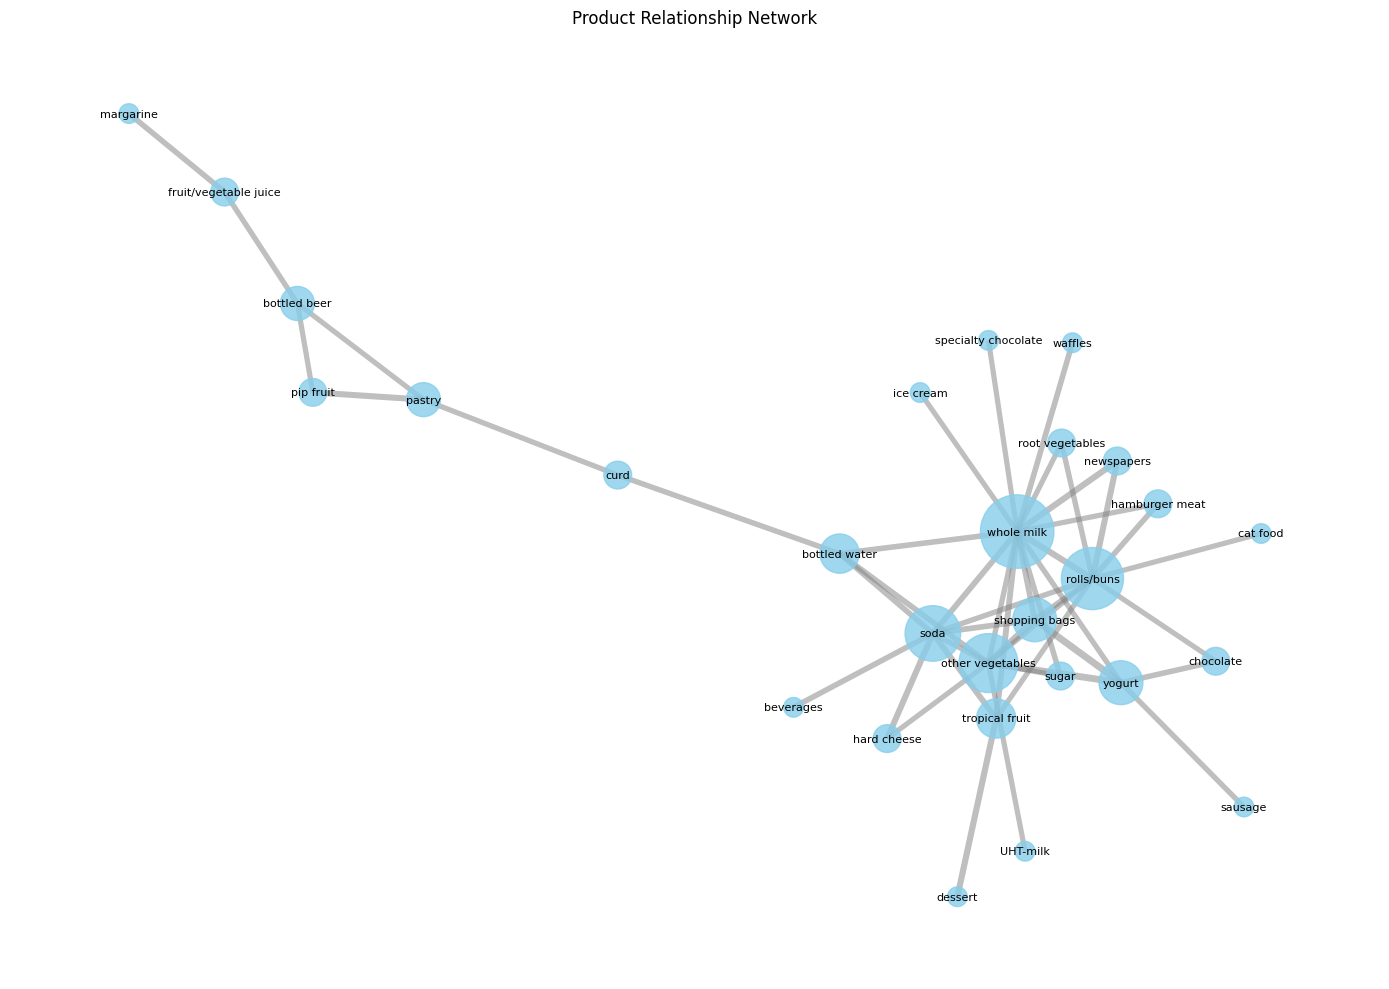

In [19]:
# Create product relationship network
def create_product_network(rules_df, min_lift=1.0, max_edges=50): # Changed default min_lift to 1.0 as in the failing code
    """Create a network graph of product relationships."""
    G = nx.Graph()

    # Ensure rules_df is not empty and has the necessary columns
    if rules_df.empty or not all(col in rules_df.columns for col in ['antecedents', 'consequents', 'lift', 'confidence']):
        print("Rules DataFrame is empty or missing required columns. Cannot create network.")
        return G # Return an empty graph

    # Filter rules by min_lift and take top ones by lift
    top_rules = rules_df[rules_df['lift'] >= min_lift].sort_values('lift', ascending=False).head(max_edges)

    # Add edges to graph
    for _, rule in top_rules.iterrows():
        # Ensure antecedent and consequent are iterable sets
        antecedent_items = list(rule['antecedents'])
        consequent_items = list(rule['consequents'])

        # Add edges between each antecedent and each consequent
        for item1 in antecedent_items:
            for item2 in consequent_items:
                # Avoid self-loops and duplicate edges (Graph is undirected)
                if item1 != item2:
                    # Use the rule's lift as weight
                    # If an edge already exists, keep the one with higher lift
                    if G.has_edge(item1, item2):
                        existing_weight = G[item1][item2]['weight']
                        if rule['lift'] > existing_weight:
                             G.add_edge(
                                item1,
                                item2,
                                weight=rule['lift'],
                                confidence=rule['confidence']
                            )
                    else:
                         G.add_edge(
                            item1,
                            item2,
                            weight=rule['lift'],
                            confidence=rule['confidence']
                        )

    return G

# Create and visualize network
# Check if the 'rules' variable exists before calling the function
if 'rules' in globals() and isinstance(rules, pd.DataFrame):
    product_network = create_product_network(rules, min_lift=1.0, max_edges=100)

    try:
        # Draw network with networkx
        plt.figure(figsize=(14, 10))

        if product_network.number_of_nodes() > 0:
            # Calculate node sizes based on degree
            degrees = dict(product_network.degree())
            # Handle potential case where degrees dictionary is empty but network has nodes (shouldn't happen normally)
            if not degrees:
                 node_sizes = [200] * product_network.number_of_nodes() # Default size if degree calculation fails
                 print("Warning: Could not calculate node degrees. Using default size.")
            else:
                 node_sizes = [v * 200 for v in degrees.values()] # Scale node sizes

            # Calculate edge widths based on lift
            edge_weights = [product_network[u][v]['weight'] for u, v in product_network.edges()]
            # Normalize weights for line thickness, handle case with no edges
            # Use a small epsilon to avoid division by zero if max_edges = 1 or all lifts are 0 (unlikely)
            max_weight = max(edge_weights) if edge_weights else 1e-6
            normalized_weights = [w / max_weight * 5 for w in edge_weights] if edge_weights else []

            # Use spring layout for better visualization
            # Added iterations for layout stability
            pos = nx.spring_layout(product_network, seed=42, k=0.5, iterations=100) # Increased iterations for potentially better layout

            # Draw the network
            nx.draw_networkx_nodes(product_network, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
            # Draw edges, using the calculated widths
            nx.draw_networkx_edges(product_network, pos, width=normalized_weights, alpha=0.5, edge_color='gray')

            # FIX: Removed 'with_labels=True' from draw_networkx_labels as it's not a valid argument
            # The default behavior of draw_networkx_labels is to draw labels if pos is provided and labels are nodes
            nx.draw_networkx_labels(product_network, pos, font_size=8) # Pass labels explicitly if needed, default is node names

            plt.title('Product Relationship Network')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("No nodes or edges in the network (after filtering by min_lift) to visualize.")

    except Exception as e:
        print(f"Network visualization failed: {e}")
        # Print basic stats even if visualization fails
        print("Network statistics:")
        print(f"Number of products: {product_network.number_of_nodes()}")
        print(f"Number of relationships: {product_network.number_of_edges()}")

else:
    print("\nSkipping Product Relationship Visualization. Please run Section 5 first to generate association rules.")
    # Print zero stats if rules or network were not created
    print("Network statistics:")
    print("Number of products: 0")
    print("Number of relationships: 0")

## 9. Business Insights and Recommendations Dashboard

In [21]:
# Create a simple dashboard for business insights
def create_business_dashboard(rules_df, revenue_df, cluster_profiles, user_profile_df, cluster_labels):
    """Create a comprehensive business dashboard from pattern mining results."""
    print("\n" + "=" * 50)
    print("PATTERN MINING BUSINESS INSIGHTS DASHBOARD")
    print("=" * 50)

    # Ensure inputs are valid
    if not isinstance(rules_df, pd.DataFrame) or rules_df.empty:
         print("\nRules data not available or is empty.")
         rules_df = pd.DataFrame(columns=['antecedents', 'consequents', 'lift', 'support', 'confidence']) # Create empty dummy
    if not isinstance(revenue_df, pd.DataFrame) or revenue_df.empty:
         print("\nRevenue impact data not available or is empty.")
         revenue_df = pd.DataFrame(columns=['antecedent_str', 'consequent_str', 'target_users', 'potential_revenue']) # Create empty dummy
    if not isinstance(cluster_profiles, pd.DataFrame) or cluster_profiles.empty:
         print("\nCluster profiles data not available or is empty.")
         cluster_profiles = pd.DataFrame() # Create empty dummy
    # user_profile_df and cluster_labels are used for segment size and labels lookup
    if not isinstance(user_profile_df, pd.DataFrame) or user_profile_df.empty or 'Cluster' not in user_profile_df.columns:
         print("\nUser profile or cluster assignment data not available.")
         user_profile_df = pd.DataFrame(columns=['User_id', 'Cluster']) # Create empty dummy
    if not isinstance(cluster_labels, dict) or not cluster_labels:
        print("\nCluster labels not available.")
        cluster_labels = {c: f'Cluster {c}' for c in cluster_profiles.index} # Try to create generic labels if profiles exist


    # 1. Top Product Associations
    print("\n1. TOP PRODUCT ASSOCIATIONS")
    print("-" * 30)
    # Filter rules with lift > 1 for positive associations
    if not rules_df.empty and 'lift' in rules_df.columns:
        top_associations = rules_df[rules_df['lift'] > 1].sort_values('lift', ascending=False).head(5)
        if top_associations.empty:
            print("No strong positive associations found above lift 1.")
        else:
            for i, (_, rule) in enumerate(top_associations.iterrows(), 1):
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                print(f"{i}. {antecedent} \u2192 {consequent}") # Using arrow symbol
                # Safely access columns using .get() or checking existence
                support = rule.get('support', np.nan)
                confidence = rule.get('confidence', np.nan)
                lift = rule.get('lift', np.nan)
                print(f"   Support: {support:.3f}, Confidence: {confidence:.3f}, Lift: {lift:.2f}")
    else:
        print("Rules DataFrame is empty or missing 'lift' column. Cannot display top associations.")


    # 2. Customer Segment Overview
    print("\n2. CUSTOMER SEGMENT OVERVIEW")
    print("-" * 30)
    if not cluster_profiles.empty and not user_profile_df.empty:
        for cluster_id, label in cluster_labels.items():
            # Safely get segment size
            segment_size = user_profile_df[user_profile_df['Cluster'] == cluster_id].shape[0] if 'Cluster' in user_profile_df.columns else 0

            # Check if cluster_id exists in cluster_profiles index
            if cluster_id in cluster_profiles.index:
                 print(f"{label}: {int(segment_size)} customers")
                 profile_data = cluster_profiles.loc[cluster_id]

                 # Safely access columns using .get()
                 avg_purchases = profile_data.get('purchase_count', np.nan)
                 avg_unique = profile_data.get('unique_items', np.nan)
                 avg_price = profile_data.get('avg_price', np.nan)

                 print(f"  Avg. purchases: {avg_purchases:.1f}" if not pd.isna(avg_purchases) else "  Avg. purchases: N/A")
                 print(f"  Avg. unique items: {avg_unique:.1f}" if not pd.isna(avg_unique) else "  Avg. unique items: N/A")

                 # FIX: Check if 'avg_price' column exists in the cluster_profiles DataFrame
                 if 'avg_price' in cluster_profiles.columns and not pd.isna(avg_price):
                     print(f"  Avg. spend: ${avg_price:.2f}")
                 else:
                     print("  Avg. spend: N/A ('Amount' column was missing in original data or profile)")
            else:
                 print(f"{label}: {int(segment_size)} customers (Profile data not available for this cluster ID)")
    else:
        print("Customer segmentation data not available or incomplete.")


    # 3. Revenue Opportunity Summary
    print("\n3. REVENUE OPPORTUNITY SUMMARY")
    print("-" * 30)
    # Ensure revenue_df is not empty and has the necessary columns for sorting/summing
    if not revenue_df.empty and 'potential_revenue' in revenue_df.columns:
        total_potential = revenue_df['potential_revenue'].sum()
        print(f"Total potential revenue across top rules: ${total_potential:.2f}")
        print("Top opportunities:")
        # Ensure antecedent_str and consequent_str columns exist for display
        if 'antecedent_str' in revenue_df.columns and 'consequent_str' in revenue_df.columns:
            top_opportunities = revenue_df.sort_values('potential_revenue', ascending=False).head(3)
            for i, (_, opportunity) in enumerate(top_opportunities.iterrows(), 1):
                antecedent = opportunity['antecedent_str']
                consequent = opportunity['consequent_str']
                # FIX: Removed invalid escape sequences \ before single quotes
                print(f"{i}. Recommend '{consequent}' to customers who bought '{antecedent}'")
                # Safely access columns
                target_users = opportunity.get('target_users', 0)
                potential_revenue_val = opportunity.get('potential_revenue', 0)
                print(f"   Target customers: {target_users}")
                print(f"   Potential revenue: ${potential_revenue_val:.2f}")
        else:
            print("Revenue DataFrame is missing 'antecedent_str' or 'consequent_str' columns.")
    else:
        print("No revenue opportunities calculated (Check if revenue_df is generated and not empty).")


    # 4. Actionable Business Recommendations
    print("\n4. ACTIONABLE BUSINESS RECOMMENDATIONS")
    print("-" * 30)
    print("1. Product Bundling: Create bundles of frequently co-purchased items based on high-lift rules.")
    print("2. Targeted Marketing: Send personalized recommendations (Section 7) or segment-specific promotions (Section 4). Choose channels like email, app notifications, or website banners.")
    print("3. Store Layout (Physical/Online): Place associated products near each other on shelves or suggest them together on product pages/checkout.")
    print("4. Pricing Strategy: Consider offering small discounts or loyalty points for purchasing associated products together to increase basket size.")
    print("5. Inventory Management: Ensure associated products identified by high-support rules are well-stocked together, especially during peak purchase times (Section 3 analysis).")
    print("6. A/B Testing: Test different recommendation strategies and measure their actual conversion rates and revenue impact (Section 10 implementation)." )

# Generate dashboard
# Ensure all required dataframes and variables exist and are not empty/invalid before calling
if 'rules' in globals() and isinstance(rules, pd.DataFrame) and \
   'revenue_df' in globals() and isinstance(revenue_df, pd.DataFrame) and \
   'cluster_profiles' in globals() and isinstance(cluster_profiles, pd.DataFrame) and \
   'user_profile_df' in globals() and isinstance(user_profile_df, pd.DataFrame) and \
   'cluster_labels' in globals() and isinstance(cluster_labels, dict):
    create_business_dashboard(rules, revenue_df, cluster_profiles, user_profile_df, cluster_labels)
else:
    print("\nSkipping dashboard generation. Please run previous sections first to create required data (rules, revenue_df, cluster_profiles, user_profile_df, cluster_labels).")


PATTERN MINING BUSINESS INSIGHTS DASHBOARD

Revenue impact data not available or is empty.

1. TOP PRODUCT ASSOCIATIONS
------------------------------
1. yogurt, other vegetables → shopping bags
   Support: 0.010, Confidence: 0.224, Lift: 1.84
2. shopping bags → yogurt, other vegetables
   Support: 0.010, Confidence: 0.085, Lift: 1.84
3. yogurt → other vegetables, shopping bags
   Support: 0.010, Confidence: 0.060, Lift: 1.82
4. other vegetables, shopping bags → yogurt
   Support: 0.010, Confidence: 0.316, Lift: 1.82
5. yogurt, shopping bags → other vegetables
   Support: 0.010, Confidence: 0.375, Lift: 1.65

2. CUSTOMER SEGMENT OVERVIEW
------------------------------
Segment 1: 1428 customers
  Avg. purchases: 5.0
  Avg. unique items: 4.8
  Avg. spend: N/A ('Amount' column was missing in original data or profile)
Segment 2: 801 customers
  Avg. purchases: 8.6
  Avg. unique items: 8.1
  Avg. spend: N/A ('Amount' column was missing in original data or profile)
Segment 3: 214 customers


## 10. Implementing Recommendations in Production

In [26]:
# ==============================================================================
# Section 10: Implementing Recommendations in Production (Refactored)
# ==============================================================================

# --- Helper Functions and Mock Objects (defined outside demo steps) ---

# Placeholder for user purchase history lookup
# In a real system, this would be a database lookup function
user_purchase_history_demo = {} # Use a different name to avoid potential confusion with code in steps

# Placeholder for a simple recommendation engine object wrapper
# This wrapper will use the 'get_recommendations' function defined in Section 7
class SimpleRecommendationEngine:
    def __init__(self, rule_lookup):
        self.rule_lookup = rule_lookup

    def recommend(self, user_items, top_n=5):
        # Call the get_recommendations function from Section 7
        # Ensure the function is available in the global scope
        if 'get_recommendations' in globals() and callable(get_recommendations):
             return get_recommendations(user_items, self.rule_lookup, top_n)
        else:
             print("Error: get_recommendations function not found or not callable.")
             return []

# Mock database collection for demonstration performance tracking
class MockCollection:
    def __init__(self, name):
        self.name = name
        self._data = []
        self._next_id = 1 # Simple way to assign unique IDs

    def insert(self, doc):
        # Assign a unique ID if not already present
        if 'rec_impression_id' not in doc:
             doc['rec_impression_id'] = self._next_id
             self._next_id += 1
        self._data.append(doc)
        # print(f"Inserted into {self.name}: {doc}") # Optional: uncomment for debug

    def update(self, query, update_data):
        matched_count = 0
        for doc in self._data:
            # Simple query matching for demo
            match = True
            for key, value in query.items():
                # Handle potential missing keys in doc gracefully
                if key not in doc or doc[key] != value:
                    match = False
                    break
            if match:
                # Apply updates from the $set dictionary
                if '$set' in update_data:
                    for update_key, update_value in update_data['$set'].items():
                         doc[update_key] = update_value
                # Handle other potential update operators if needed, e.g., $inc
                matched_count += 1
        # print(f"Updated {matched_count} documents in {self.name} for query {query}") # Optional: uncomment for debug
        return matched_count # Return count like some DB update methods


    def count(self, query=None):
        if query is None:
            return len(self._data)
        count = 0
        for doc in self._data:
             match = True
             for key, value in query.items():
                 # Handle potential missing keys in doc gracefully
                 if key not in doc or doc[key] != value:
                     match = False
                     break
             if match:
                 count += 1
        return count

    def find(self, query=None):
         if query is None:
             return iter(self._data)
         results = []
         for doc in self._data:
              match = True
              for key, value in query.items():
                  # Handle potential missing keys in doc gracefully
                  if key not in doc or doc[key] != value:
                      match = False
                      break
              if match:
                  results.append(doc)
         return iter(results) # Return an iterator like a real cursor

# Initialize mock database collections
db = type('MockDatabase', (object,), {})
db.recommendation_impressions = MockCollection('recommendation_impressions')


# Recommendation API function (using the SimpleRecommendationEngine wrapper)
def get_user_recommendations_api(user_id, recommendation_engine_instance, top_n=5):
    # In a real scenario, fetch user items for the given user_id from a database
    # For demo, we'll use the previously loaded train_data if available
    user_items = []
    # Check if train_data is loaded and not empty before accessing it
    if 'train_data' in globals() and isinstance(train_data, pd.DataFrame) and not train_data.empty and user_id in train_data['User_id'].unique():
        user_items = list(train_data[train_data['User_id'] == user_id]['itemDescription'].unique())

    if not user_items:
        # print(f"No purchase history found for user {user_id}") # Optional debug
        return [] # No purchase history for user

    # Generate recommendations using the engine instance
    recs = recommendation_engine_instance.recommend(user_items, top_n)
    # Format recommendations for API output
    formatted_recs = [{'item': item, 'lift': lift, 'confidence': conf} for item, lift, conf in recs]
    return formatted_recs


# Marketing Campaign Integration function
from collections import Counter # Ensure Counter is imported here

def prepare_recommendation_campaign(segments_data, rec_engine):
    recommendations_by_segment = {}

    if not segments_data:
        print("No segment data to process.")
        return {}

    print("Preparing recommendations per segment...")
    # Iterate through segments_data which should be {label: [user_ids]}
    for segment_label, user_list in segments_data.items():
        print("Processing segment: {} ({} users)".format(segment_label, len(user_list)))
        segment_recommendations_raw = []

        # Get recommendations for a sample of users in the segment
        sample_size = min(len(user_list), 50) # Limit sample size for demo
        if sample_size == 0:
             print("  No users in segment {}.".format(segment_label))
             continue

        for user_id in user_list[:sample_size]:
            # Fetch user items for the specific user_id (using train_data for demo)
            user_items = []
            # Check if train_data is loaded and not empty
            if 'train_data' in globals() and isinstance(train_data, pd.DataFrame) and not train_data.empty and user_id in train_data['User_id'].unique():
                 user_items = list(train_data[train_data['User_id'] == user_id]['itemDescription'].unique())

            if user_items:
                user_recs = rec_engine.recommend(user_items, top_n=5) # Get top 5 recs per user
                # user_recs format: [(item, lift, confidence), ...]
                # We only need the item names for counting popular items in segment
                segment_recommendations_raw.extend([item for item, lift, conf in user_recs])
            # else: # Optional debug
                 # print(f"  No purchase history for user {user_id} in segment {segment_label}. Skipping recommendations.")


        # Get most common recommendations for this segment
        if segment_recommendations_raw:
            top_segment_recs = Counter(segment_recommendations_raw).most_common(10) # Top 10 items for the segment
            recommendations_by_segment[segment_label] = top_segment_recs
            print("  Top recommendations for {}: {}".format(segment_label, top_segment_recs))
        else:
             print("  Could not generate recommendations for sample users in segment {}.".format(segment_label))

    return recommendations_by_segment

# Performance Monitoring Functions (using the mock db)
import datetime # Ensure datetime is imported here

def track_recommendation_performance(recommendation_id, user_id, item_id, timestamp):
    # Record when recommendations are shown to a user
    db.recommendation_impressions.insert({
        'rec_impression_id': recommendation_id, # Unique ID for this specific display event
        'user_id': user_id,
        'item_id': item_id, # The item that was recommended
        'timestamp': timestamp,
        'conversion': False,
        'amount': 0 # Placeholder for potential revenue
    })

def track_purchase_conversion(user_id, purchased_item_id, purchase_timestamp, amount):
    # When a user makes a purchase, check if any recently displayed recommendations were bought
    # This requires matching purchased items back to displayed recommendations
    # A more robust system would track which impression led to a purchase.
    # For this simplified demo, we'll update any *outstanding* impression for this user/item.

    # Simple demo logic: Mark any unconverted impression for this user/item as converted
    query = {
        'user_id': user_id,
        'item_id': purchased_item_id,
        'conversion': False # Only update unconverted impressions
    }
    update_data = {
        '$set': {
            'conversion': True,
            'conversion_time': purchase_timestamp,
            'amount': float(amount) # Ensure amount is a float/number
        }
    }
    db.recommendation_impressions.update(query, update_data)


def calculate_recommendation_roi():
    # Calculate ROI or basic performance metrics of recommendation system
    total_conversions = db.recommendation_impressions.count({'conversion': True})
    total_impressions = db.recommendation_impressions.count() # Total times *any* item was recommended

    conversion_rate = total_conversions / total_impressions if total_impressions > 0 else 0

    # Ensure 'amount' is treated as a number, defaulting to 0 if missing or invalid
    total_revenue = sum(r.get('amount', 0) for r in db.recommendation_impressions.find({'conversion': True}))

    return {
        'conversion_rate': conversion_rate,
        'total_revenue': total_revenue,
        'impressions': total_impressions,
        'conversions': total_conversions
    }


# --- Main Demo Implementation Function ---

def demo_recommendation_implementation():
    """Demonstrate how to implement recommendations in a production environment."""
    print("\nImplementing Pattern Mining Recommendations")
    print("=" * 40)

    # --- Demo Step 1: Create a recommendation API ---
    print("\n1. Create a recommendation API")
    print("-" * 30)

    # Check if the recommendation engine from Section 7 is available
    if 'recommendation_engine' in globals() and isinstance(recommendation_engine, dict):
        # Initialize the recommendation engine wrapper
        demo_engine_api = SimpleRecommendationEngine(recommendation_engine)

        # Example of calling the API function sketch
        # For a sample user ID that exists in train_data
        # Check if train_data is loaded and not empty before accessing it
        if 'train_data' in globals() and isinstance(train_data, pd.DataFrame) and not train_data.empty:
            # Get a real user ID from the data if possible
            sample_user_id_for_api_demo = train_data['User_id'].iloc[0]
            print("--- API Demo for user: {} ---".format(sample_user_id_for_api_demo))
            api_recs = get_user_recommendations_api(sample_user_id_for_api_demo, demo_engine_api)
            print(api_recs)
        else:
            print("train_data not loaded or empty. Cannot run API demo.")

        print("---------------------------------")
        # Example API endpoint sketch (commented out as it requires a web framework)
        # @app.route('/recommendations/<user_id>')
        # def api_recommendations_endpoint(user_id):
        #     recs = get_user_recommendations_api(user_id, demo_engine_api)
        #     return jsonify(recs)

    else:
        print("Recommendation engine 'recommendation_engine' from Section 7 not built. Skipping API demo.")
        print("---------------------------------")


    # --- Demo Step 2: Integrate with marketing campaigns ---
    print("\n2. Integrate with marketing campaigns")
    print("-" * 30)

    # For demo, let's map cluster IDs to user IDs from Section 4
    customer_segments = {}
    # Check if user_profile_df and cluster_labels are accessible and valid
    if 'user_profile_df' in globals() and isinstance(user_profile_df, pd.DataFrame) and not user_profile_df.empty and \
       'cluster_labels' in globals() and isinstance(cluster_labels, dict):
        if 'Cluster' in user_profile_df.columns:
            for cluster_id, label in cluster_labels.items():
                # Get user IDs for this cluster
                user_ids_in_cluster = user_profile_df[user_profile_df['Cluster'] == cluster_id].index.tolist()
                customer_segments[label] = user_ids_in_cluster
            print("--- Marketing Integration Demo (Recommendations by Segment) ---")
            print("Identified Segments:", list(customer_segments.keys()))

            # Check if the recommendation engine is available for campaign prep
            if 'recommendation_engine' in globals() and isinstance(recommendation_engine, dict):
                 # Create a simple engine instance wrapper for the function
                 demo_engine_campaign = SimpleRecommendationEngine(recommendation_engine)
                 campaign_recommendations = prepare_recommendation_campaign(customer_segments, demo_engine_campaign)
                 # print("\nCampaign Recommendations Summary:", campaign_recommendations) # Optional print
            else:
                 print("\nRecommendation engine 'recommendation_engine' from Section 7 not built. Cannot prepare campaign recommendations.")

        else:
            print("User profile data is missing 'Cluster' column. Cannot segment customers for marketing demo.")
    else:
         print("Segmentation data (user_profile_df, cluster_labels) not available or incomplete.")
         print("Please run Section 4 to create customer segments.")

    print("---------------------------------")


    # --- Demo Step 3: Monitor recommendation performance ---
    print("\n3. Monitor recommendation performance")
    print("-" * 30)

    print("--- Performance Monitoring Demo ---")

    # Simulate some recommendation impressions and conversions
    # Clear previous mock data for a fresh demo run if needed
    db.recommendation_impressions._data = []
    db.recommendation_impressions._next_id = 1

    # User 1 is shown recommendations
    user1 = 'User_A'
    now = datetime.datetime.now()
    track_recommendation_performance('rec_id_001', user1, 'item_X', now)
    track_recommendation_performance('rec_id_002', user1, 'item_Y', now)

    # User 2 is shown recommendations
    user2 = 'User_B'
    now_plus_5m = now + datetime.timedelta(minutes=5)
    track_recommendation_performance('rec_id_003', user2, 'item_A', now_plus_5m)
    track_recommendation_performance('rec_id_004', user2, 'item_B', now_plus_5m)
    track_recommendation_performance('rec_id_005', user2, 'item_C', now_plus_5m)

    # User 1 buys item_Y (converted)
    now_plus_10m = now + datetime.timedelta(minutes=10)
    track_purchase_conversion(user1, 'item_Y', now_plus_10m, 15.50) # Assuming item_Y costs $15.50

    # User 2 buys item_A and item_C (converted)
    now_plus_12m = now + datetime.timedelta(minutes=12)
    track_purchase_conversion(user2, 'item_A', now_plus_12m, 5.00) # Assuming item_A costs $5.00
    track_purchase_conversion(user2, 'item_C', now_plus_12m, 25.00) # Assuming item_C costs $25.00

    # Calculate and print performance metrics
    performance_metrics = calculate_recommendation_roi()

    print("Recommendation Performance Metrics:")
    print("  Total Impressions: {}".format(performance_metrics['impressions']))
    print("  Total Conversions: {}".format(performance_metrics['conversions']))
    # Ensure conversion rate is multiplied by 100 for percentage display
    print("  Conversion Rate: {:.2f}%".format(performance_metrics['conversion_rate'] * 100))
    print("  Revenue from Conversions: ${:.2f}".format(performance_metrics['total_revenue']))
    print("---------------------------------")


# Show implementation demo
# Ensure recommendation_engine from Section 7 is built and 'get_recommendations' is defined
if 'recommendation_engine' in globals() and isinstance(recommendation_engine, dict) and \
   'get_recommendations' in globals() and callable(get_recommendations):
    # Check for other prerequisites and warn if missing, but proceed with demo
    if 'train_data' not in globals() or not isinstance(train_data, pd.DataFrame) or train_data.empty:
         print("\nWarning: train_data not loaded or is empty. Some parts of the demo (API user history lookup, campaign user history lookup) may be limited or skipped.")
    if 'user_profile_df' not in globals() or not isinstance(user_profile_df, pd.DataFrame) or user_profile_df.empty or \
       'cluster_labels' not in globals() or not isinstance(cluster_labels, dict):
           print("\nWarning: Segmentation data (user_profile_df, cluster_labels) not found or incomplete. Marketing Integration demo will be limited or skipped.")

    demo_recommendation_implementation()
else:
    print("\nSkipping implementation demo. Please run Section 7 to build the recommendation engine ('recommendation_engine') and ensure 'get_recommendations' function is defined.")


Implementing Pattern Mining Recommendations

1. Create a recommendation API
------------------------------
--- API Demo for user: 2351.0 ---
[{'item': 'yogurt', 'lift': 1.8420836751435603, 'confidence': 0.08490566037735849}, {'item': 'other vegetables', 'lift': 1.8420836751435603, 'confidence': 0.08490566037735849}, {'item': 'soda', 'lift': 1.5050571480406385, 'confidence': 0.08962264150943396}, {'item': 'whole milk', 'lift': 1.5050571480406385, 'confidence': 0.08962264150943396}, {'item': 'rolls/buns', 'lift': 1.4939754619219865, 'confidence': 0.08254716981132075}]
---------------------------------

2. Integrate with marketing campaigns
------------------------------
--- Marketing Integration Demo (Recommendations by Segment) ---
Identified Segments: ['Segment 1', 'Segment 2', 'Segment 3', 'Segment 4']
Preparing recommendations per segment...
Processing segment: Segment 1 (1428 users)
  Top recommendations for Segment 1: [('whole milk', 29), ('rolls/buns', 24), ('shopping bags', 22),

## 11. Conclusion & Next Steps

In [23]:
# Print conclusion and next steps
print("\nConclusion & Next Steps")
print("=" * 25)


Conclusion & Next Steps


This notebook has demonstrated how to:
1. Segment customers based on purchasing behavior
2. Mine frequent patterns and association rules
3. Calculate potential business value of recommendations
4. Build a product recommendation engine
5. Visualize product relationships
6. Create a business insights dashboard
7. Implement recommendations in a production environment

Next steps:
1. A/B test the recommendation engine with different algorithms
2. Incorporate temporal patterns (seasonal trends, purchase sequences)
3. Combine collaborative filtering with association rules for hybrid recommendations
4. Implement real-time recommendation updates as user behavior changes
5. Develop more sophisticated business value metrics